In [1]:
from torchvision import datasets

data_path = './data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
img, label = cifar10[99]
img, label

(<PIL.Image.Image image mode=RGB size=32x32>, 1)

In [3]:
## I have to first define what class_names is
class_names = cifar10.classes
class_names[label]

'automobile'

In [4]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [5]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())
tensor_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False, transform=transforms.ToTensor())

In [6]:
img_t, _ = tensor_cifar10[99]
type(img_t), img_t.shape, img_t.dtype

(torch.Tensor, torch.Size([3, 32, 32]), torch.float32)

In [7]:
## Normalizing the data
import torch

imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape


torch.Size([3, 32, 32, 50000])

In [8]:
## Compute mean and std per channel

imgs.view(3,-1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [9]:
imgs.view(3,-1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [10]:
## Normalize validation data
imgs_val = torch.stack([img_t for img_t, _ in tensor_cifar10_val], dim=3)
imgs_val.shape

torch.Size([3, 32, 32, 10000])

In [11]:
imgs_val.view(3,-1).mean(dim=1)

tensor([0.4942, 0.4851, 0.4504])

In [12]:
imgs_val.view(3,-1).std(dim=1)

tensor([0.2467, 0.2429, 0.2616])

In [13]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                                                (0.2470, 0.2435, 0.2616))])
)

transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4942, 0.4851, 0.4504),
                                                                                                (0.2467, 0.2429, 0.2616))])
)

In [14]:
## Distinguiching birds from airplanes

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [15]:
transformed_cifar2 = [ (img, label_map[label]) for img, label in transformed_cifar10 if label in [0,2]]
transformed_cifar2_val = [ (img, label_map[label]) for img, label in transformed_cifar10_val if label in [0,2]]

In [16]:
## Making the NN

import torch.nn as nn

n_out = 2
model = nn.Sequential(
    nn.Linear(3*32*32, 512,),
    nn.Tanh(),
    nn.Linear(512, n_out,),
    nn.LogSoftmax(dim=1)
    )


In [17]:
loss_fn = nn.NLLLoss()

In [21]:
## Function to reset the weights every time i want to rerun the training process
import torch.nn.init as init

def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


In [18]:
import torch.optim as optim

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 100

In [ ]:
for epoch in range(1,n_epochs+1):
  for img, label in transformed_cifar2:
    out = model(img.view(-1).unsqueeze(0))
    loss = loss_fn(out, torch.tensor([label]))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Training loss {loss.item():.4f}")


In [19]:
## Use DataLoader to define minibatches and train more efficiently
train_loader = torch.utils.data.DataLoader(transformed_cifar2, batch_size=64, shuffle=True)

In [22]:
reset_weights(model)

n_epochs = 50

for epoch in range(n_epochs+1):
  for imgs, labels in train_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size,-1))
    loss = loss_fn(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 5 == 0:
    print(f"Epoch {epoch}, Training loss {loss.item():.4f}")


Epoch 0, Training loss 0.3505
Epoch 5, Training loss 0.4009
Epoch 10, Training loss 0.4433
Epoch 15, Training loss 0.2877
Epoch 20, Training loss 0.4919
Epoch 25, Training loss 0.3228
Epoch 30, Training loss 0.2319
Epoch 35, Training loss 0.1826
Epoch 40, Training loss 0.0627
Epoch 45, Training loss 0.0737
Epoch 50, Training loss 0.0326


In [23]:
## Include the validation data to get a sense of how good the model is

val_loader = torch.utils.data.DataLoader(transformed_cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
  for imgs, labels in val_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size,-1))
    _ , predicted = torch.max(outputs, dim=1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
print(f"Accuracy: {correct/total}")

Accuracy: 0.8205


In [24]:
## Improve the model

model = nn.Sequential(
    nn.Linear(3*32*32, 1024),
    nn.Tanh(),
    nn.Linear(1024,512),
    nn.Tanh(),
    nn.Linear(512,128),
    nn.Tanh(),
    nn.Linear(128,2)
)

loss_fn = nn.CrossEntropyLoss()

In [25]:
numel_list = [ p.numel() for p  in model.parameters() if p.requires_grad == True]

sum(numel_list), numel_list


(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

# Ex. 1

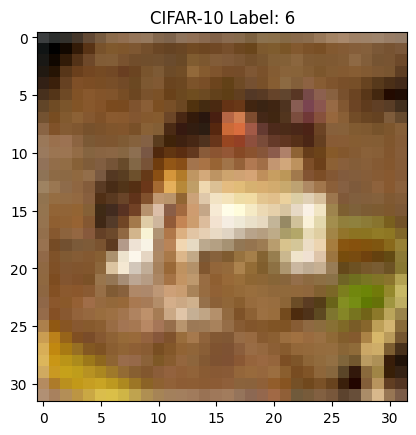

In [30]:
import torchvision
import matplotlib.pyplot as plt

image0, label0 = tensor_cifar10[0]

# Convert the PyTorch tensor to a NumPy array and transpose the dimensions
image0_np = image0.numpy().transpose((1, 2, 0))

# Display the image using matplotlib
plt.imshow(image0_np)
plt.title(f'CIFAR-10 Label: {label0}')
plt.show()


Every time I run the following cell, I get a different cropped image, as expected.

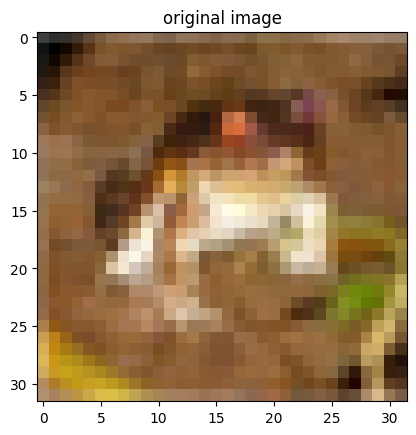

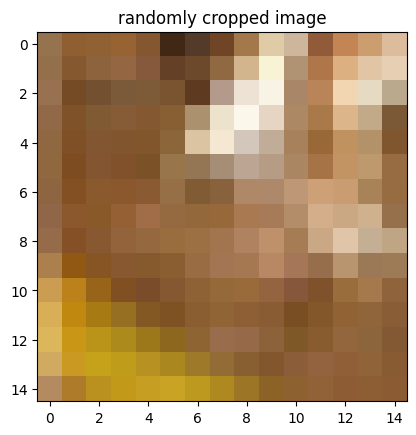

In [31]:
from PIL import Image

# Define a random cropping transform
random_crop_transform = transforms.RandomCrop(size=(15, 15))

# Apply the random cropping transform to the image
cropped_image = random_crop_transform(image0)
cropped_image_np = cropped_image.numpy().transpose((1,2,0))

# Display the original and cropped images
plt.imshow(image0_np)
plt.title(f'original image')
plt.show()

# Display the image using matplotlib
plt.imshow(cropped_image_np)
plt.title(f'randomly cropped image')
plt.show()



In [32]:
cifar2_cropped = [(random_crop_transform(img), label) for img, label in cifar2]
cifar2_val_cropped = [(random_crop_transform(img), label) for img, label in cifar2_val]

In [33]:
tensor_cifar2_cropped = [(transforms.ToTensor()(img), label) for img , label in cifar2_cropped]
tensor_cifar2_val_cropped = [ (transforms.ToTensor()(img), label) for img, label in cifar2_val_cropped]
imgs_cropped = torch.stack([img_t for img_t, _ in tensor_cifar2_cropped], dim=3)
imgs_val_cropped = torch.stack([img_t for img_t , _ in tensor_cifar2_val_cropped], dim=3)


In [34]:
imgs_val_cropped.view(3,-1).mean(dim=1)

tensor([0.4993, 0.5119, 0.4947])

In [35]:
cropped_transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.4966, 0.5066, 0.4865),(0.2346, 0.2301, 0.2596))])
cropped_val_transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.4991, 0.5119, 0.4948),(0.2357, 0.2323, 0.2611))])

In [36]:
transformed_cifar2_cropped = [(cropped_transform(img), label) for img, label in cifar2_cropped]
transformed_cifar2_val_cropped = [(cropped_val_transform(img), label) for img, label in cifar2_val_cropped]

In [37]:
cropped_train_loader = torch.utils.data.DataLoader(transformed_cifar2_cropped, batch_size=64, shuffle=True)
cropped_val_loader = torch.utils.data.DataLoader(transformed_cifar2_val_cropped, batch_size=64, shuffle=False)


In [38]:
## Redifine the model for the cropped input
cropped_model = nn.Sequential(
    nn.Linear(3*15*15,512),
    nn.Tanh(),
    nn.Linear(512,128),
    nn.Tanh(),
    nn.Linear(128,2)
)

loss_fn = nn.CrossEntropyLoss()

In [39]:
reset_weights(cropped_model)

In [40]:
# I want to run the training loop on randomly cropped images

n_epochs = 50

for epoch in range(n_epochs+1):
  for imgs, labels in cropped_train_loader:
    batch_size = imgs.shape[0]
    outputs = cropped_model(imgs.view(batch_size,-1))
    loss = loss_fn(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 5 == 0:
    print(f"Epoch {epoch}, Training loss {loss.item():.4f}")

# When I use the randomly cropped images, it trains much faster but I've also reduced the size of the model


Epoch 0, Training loss 0.7046
Epoch 5, Training loss 0.7293
Epoch 10, Training loss 0.6956
Epoch 15, Training loss 0.7128
Epoch 20, Training loss 0.7120
Epoch 25, Training loss 0.7266
Epoch 30, Training loss 0.6974
Epoch 35, Training loss 0.6775
Epoch 40, Training loss 0.6916
Epoch 45, Training loss 0.6926
Epoch 50, Training loss 0.7705


# Ex. 2

In [42]:
## In order to use MSELoss I need to change the output of the model so that it is the same thing as the labels so that I can compare them

cropped_model2 = nn.Sequential(
    nn.Linear(3*15*15,512),
    nn.Tanh(),
    nn.Linear(512,128),
    nn.Tanh(),
    nn.Linear(128,2),
    nn.Sigmoid()
)


In [43]:
reset_weights(cropped_model2)

In [44]:
new_loss_fn = nn.MSELoss()

n_epochs = 50

for epoch in range(n_epochs+1):
  for imgs, labels in cropped_train_loader:
    batch_size = imgs.shape[0]
    outputs = cropped_model2(imgs.view(batch_size,-1))
    labels = torch.nn.functional.one_hot(labels, num_classes=2).float()
    loss = new_loss_fn(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 5 == 0:
    print(f"Epoch {epoch}, Training loss {loss.item():.4f}")
## MSELoss does not work with the previous setup because the outputs and the labels are not the same size.
## This can be fixed if I one-hot encode the labels and change the output of the model from 0 to 1 using the Sigmoid activation function.
## It seems like the loss decreases slower with MSELoss

Epoch 0, Training loss 0.2601
Epoch 5, Training loss 0.2520
Epoch 10, Training loss 0.2626
Epoch 15, Training loss 0.2533
Epoch 20, Training loss 0.2537
Epoch 25, Training loss 0.2541
Epoch 30, Training loss 0.2602
Epoch 35, Training loss 0.2481
Epoch 40, Training loss 0.2441
Epoch 45, Training loss 0.2488
Epoch 50, Training loss 0.2489


In [45]:
reset_weights(cropped_model2)

In [46]:
new_loss_fn = nn.BCELoss()

n_epochs = 50

for epoch in range(n_epochs+1):
  for imgs, labels in cropped_train_loader:
    batch_size = imgs.shape[0]
    outputs = cropped_model2(imgs.view(batch_size,-1))
    labels = torch.nn.functional.one_hot(labels, num_classes=2).float()
    loss = new_loss_fn(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 5 == 0:
    print(f"Epoch {epoch}, Training loss {loss.item():.4f}")

Epoch 0, Training loss 0.7093
Epoch 5, Training loss 0.6709
Epoch 10, Training loss 0.7022
Epoch 15, Training loss 0.6740
Epoch 20, Training loss 0.6805
Epoch 25, Training loss 0.6956
Epoch 30, Training loss 0.6870
Epoch 35, Training loss 0.6808
Epoch 40, Training loss 0.6806
Epoch 45, Training loss 0.7132
Epoch 50, Training loss 0.6805


# Ex. 3

In [47]:
## I will check the cropped model first

correct = 0
total = 0

with torch.no_grad():
  for imgs, labels in cropped_val_loader:
    batch_size = imgs.shape[0]
    outputs = cropped_model(imgs.view(batch_size,-1))
    _ , predicted = torch.max(outputs, dim=1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
print(f"Accuracy: {correct/total}")

Accuracy: 0.46


In [54]:
## Redifine the model for the cropped input
new_cropped_model = nn.Sequential(
    nn.Linear(3*15*15,50),
    nn.Tanh(),
    nn.Linear(50,12),
    nn.Tanh(),
    nn.Linear(12,2)
)

loss_fn = nn.CrossEntropyLoss()

In [55]:
n_epochs = 50

for epoch in range(n_epochs+1):
  for imgs, labels in cropped_train_loader:
    batch_size = imgs.shape[0]
    outputs = new_cropped_model(imgs.view(batch_size,-1))
    loss = loss_fn(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 5 == 0:
    print(f"Epoch {epoch}, Training loss {loss.item():.4f}")

Epoch 0, Training loss 0.6905
Epoch 5, Training loss 0.7144
Epoch 10, Training loss 0.8255
Epoch 15, Training loss 0.6889
Epoch 20, Training loss 0.7298
Epoch 25, Training loss 0.5921
Epoch 30, Training loss 0.7425
Epoch 35, Training loss 0.6261
Epoch 40, Training loss 0.6858
Epoch 45, Training loss 0.6615
Epoch 50, Training loss 0.6506


In [56]:
correct = 0
total = 0

with torch.no_grad():
  for imgs, labels in cropped_val_loader:
    batch_size = imgs.shape[0]
    outputs = new_cropped_model(imgs.view(batch_size,-1))
    _ , predicted = torch.max(outputs, dim=1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
print(f"Accuracy: {correct/total}")
# As expected the model performs better on the validation dataset once I reduce its capacity so that it stops overfitting as much.

Accuracy: 0.504
